# 소프트웨어 재판매 이익예측 form Tayko by KH

## 라이브러리 임포트

In [476]:
from pathlib import Path

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

%matplotlib inline

print(sklearn.__version__)


1.2.1


## 데이타프레임 생성 및 변수 정리

In [477]:
soft_df = dmba.load_data('tayko.csv')
soft_df = soft_df.iloc[0:2000]

In [478]:
print(soft_df.columns.values[20])
print(soft_df.columns.values[21])

Web order
Gender=male


In [479]:
# 컬럼 이름 바꾸기
soft_df.columns.values[20] = 'WebOrder'
soft_df.columns.values[21] = 'GenderMale'

In [480]:
#모든 컬럼 확인
#print(soft_df)

In [481]:
# 컬럼 삭제 
soft_df.drop(['source_a','source_c','source_b','source_d','source_e'
             ,'source_m','source_o','source_h','source_r','source_s'
             ,'source_t','source_u','source_p','source_x','source_w'
             ,'1st_update_days_ago','Purchase'], axis=1, inplace=True)

In [482]:
print(soft_df)

      sequence_number  US  Freq  last_update_days_ago  WebOrder  GenderMale  \
0                   1   1     2                  3662         1           0   
1                   2   1     0                  2900         1           1   
2                   3   1     2                  3883         0           0   
3                   4   1     1                   829         0           1   
4                   5   1     1                   869         0           0   
...               ...  ..   ...                   ...       ...         ...   
1995             1996   1     1                  1701         1           0   
1996             1997   1     1                  2633         1           1   
1997             1998   1     0                  3394         0           0   
1998             1999   1     1                   253         0           1   
1999             2000   1     1                  1261         0           0   

      Address_is_res  Spending  
0                 

In [483]:
#null data 확인
#soft_df.isnull()

In [484]:
#null data 확인
soft_df.isnull().sum()

sequence_number         0
US                      0
Freq                    0
last_update_days_ago    0
WebOrder                0
GenderMale              0
Address_is_res          0
Spending                0
dtype: int64

In [485]:
# 만약 null 값이 있을 경우 삭제방법
# soft_df = soft_df.dropna()   null값이 있는 모든 행 삭제
# 또는 soft_df = df.dropna(axis=1)   null값이 있는 열(coulumn) 모두 제거

In [486]:
#숫자형 데이터의 기술 통계 정보를 요약
print(soft_df.describe())

       sequence_number           US         Freq  last_update_days_ago  \
count      2000.000000  2000.000000  2000.000000           2000.000000   
mean       1000.500000     0.824500     1.417000           2155.101000   
std         577.494589     0.380489     1.405738           1141.302846   
min           1.000000     0.000000     0.000000              1.000000   
25%         500.750000     1.000000     1.000000           1133.000000   
50%        1000.500000     1.000000     1.000000           2280.000000   
75%        1500.250000     1.000000     2.000000           3139.250000   
max        2000.000000     1.000000    15.000000           4188.000000   

          WebOrder   GenderMale  Address_is_res    Spending  
count  2000.000000  2000.000000     2000.000000  2000.00000  
mean      0.426000     0.524500        0.221000   102.62500  
std       0.494617     0.499524        0.415024   186.78261  
min       0.000000     0.000000        0.000000     0.00000  
25%       0.000000     

# a. 범주별 소비금액의 평균과 표준편차

### 미국주소(US)와 소비금액(Spending)의 평균과 표준편차

# 평균(mean)과 표준편차(standard deviation)는 통계학에서 자주 사용되는 개념
1. 평균 : 데이터의 대푯값을 나타내며, 데이터의 분포를 대략적으로 파악가능.
대부분 데이터가 정규분포(normal distribution)를 따르기 때문에 평균은 분포의 중심을 나타냄

2. 표준편차 : 데이터의 분산을 나타내며, 데이터가 평균값을 중심으로 얼마나 퍼져있는지를 나타냄. 
표준편차가 작을수록 데이터가 평균값에 모여있는 경향이 있으며, 크면 데이터가 흩어지는 경향이 존재.

3. 구하는 이유
 a) 데이터의 대푯값 파악: 평균은 데이터의 대푯값을 나타내므로, 데이터의 특징을 대략적으로 파악
    (ex) 어떤 반의 평균 점수가 다른 반의 평균 점수보다 높다면, 해당 반의 학생들이 더 잘 공부했을 가능성이 존재

 b) 이상치(outlier) 탐지: 이상치란 대부분의 데이터와 동떨어진 값으로, 
    이상치가 포함되어 있으면 평균과 표준편차가 왜곡될 수 있음. 
    이상치를 찾아서 제거하면 정확한 평균과 표준편차를 구할 수 있음.

 c) 통계적 분석: 평균과 표준편차는 다양한 통계적 분석에 사용됩니다. 
    (ex) t-test, ANOVA 등의 검정에서는 평균과 표준편차를 이용하여 두 그룹간의 차이가 통계적으로 유의한지를 판단

In [487]:
gor_df = soft_df.groupby('US').agg({'Spending':['mean','std']})
print(gor_df)

      Spending            
          mean         std
US                        
0   101.216524  174.844401
1   102.924803  189.275664


In [488]:
#Freq 출력
#print(soft_df['Freq'])

In [489]:
#dum = pd.get_dummies(soft_df['Freq'])
#print(dum)

### 거래 건(Freq)와 소비금액(Spending)의 평균과 표준편차

In [490]:
gor_df = soft_df.groupby(['Freq'])['Spending'].agg(['mean','std'])
print(gor_df)

             mean         std
Freq                         
0        0.000000    0.000000
1       66.322476  104.424412
2      123.479714  151.509696
3      234.993243  226.259754
4      306.061224  165.153642
5      459.862069  270.661719
6      556.750000  344.195009
7      642.125000  520.126478
8      933.500000  324.925120
9      870.500000  433.828307
10    1199.000000   21.213203
11    1334.000000  151.320851
12    1320.500000  177.483802
13    1443.000000         NaN
15    1133.000000         NaN


### 최근갱신일(last_update_days_ago)와 소비금액(Spending)의 평균과 표준편차

In [491]:
gor_df = soft_df.groupby(['last_update_days_ago'])['Spending'].agg(['mean','std'])
print(gor_df)

                            mean         std
last_update_days_ago                        
1                     109.000000         NaN
7                     129.000000         NaN
9                     196.000000         NaN
14                    303.000000         NaN
15                     71.000000  100.409163
...                          ...         ...
4065                   64.750000   58.987993
4096                   75.666667   93.681731
4127                   17.500000   24.748737
4157                   75.666667   95.516840
4188                   88.000000   76.374079

[940 rows x 2 columns]


### 웹 주문여부(Web_order)와 소비금액(Spending)의 평균과 표준편차

In [492]:
gor_df = soft_df.groupby(['WebOrder'])['Spending'].agg(['mean','std'])
print(gor_df)

                mean         std
WebOrder                        
0          82.902439  173.417088
1         129.199531  200.463840


### 성별(GenderMale)와 소비금액(Spending)의 평균과 표준편차

In [493]:
gor_df = soft_df.groupby(['GenderMale'])['Spending'].agg(['mean','std'])
print(gor_df)

                  mean        std
GenderMale                       
0           107.339642  190.83233
1            98.350810  183.02006


### 주소(Address_is_res)와 소비금액(Spending)의 평균과 표준편차

In [494]:
gor_df = soft_df.groupby(['Address_is_res'])['Spending'].agg(['mean','std'])
print(gor_df)

                      mean         std
Address_is_res                        
0               105.306162  199.521159
1                93.174208  132.204281


# B. 연속형 변수들에 대한 산점도(2개)작성하여 소비금액과의 관계 탐색

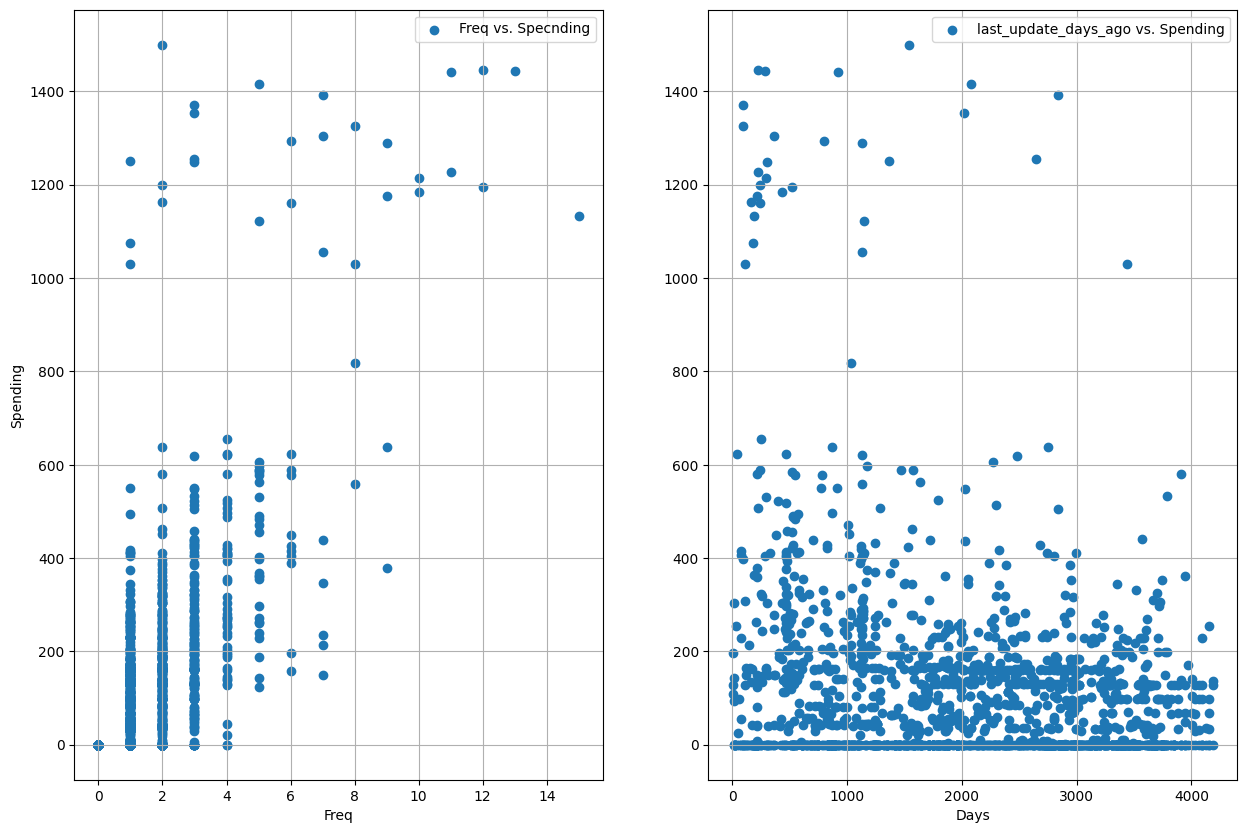

In [495]:
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
ax[0].scatter(soft_df['Freq'],soft_df['Spending'],label = 'Freq vs. Specnding')
ax[0].set_xlabel('Freq'), ax[0].set_ylabel('Spending')
ax[0].legend()  #범례 표시
ax[0].grid(True)
ax[1].scatter(soft_df['last_update_days_ago'],soft_df['Spending'],label = 'last_update_days_ago vs. Spending')
ax[1].set_xlabel('Days'), ax[0].set_ylabel('Spending')
ax[1].legend()  # 범례표시 및 (loc='left') 위치 표시 
ax[1].grid(True)
plt.show()

# c. 예측모델 구현, 회귀식, 성능평가

  
  
  ## 모델 생성
predictiors : 독립변수로 사용할 변수 선택  
outcome : 종속변수로 사용할 변수 선택

In [496]:
predictors = ['US', 'Freq', 'last_update_days_ago', 'WebOrder', 'GenderMale', 'Address_is_res']   #독립변수
outcome = 'Spending'    # 종속변수

# partition data 
X = soft_df[predictors]  #범주형 변수를 더미변수로 변환
y = soft_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=1) # 학습데이터와 검증데이터(7:3)로 분할

# 데이터 확인
print('[학습데이터 & 검증데이터 분할 확인]')
print('1) 원본 데이터셋의 shape   : ',X.shape)
print('2) 레이블 데이터셋의 shape : ',y.shape)
print('3) 학습셋의 shape        : ', train_X.shape)
print('4) 학습셋 label의 shape  : ', train_y.shape)
print('5) 검증셋의 shape        : ', valid_X.shape)
print('6) 검증셋 label의 shape  : ', valid_y.shape)

[학습데이터 & 검증데이터 분할 확인]
1) 원본 데이터셋의 shape   :  (2000, 6)
2) 레이블 데이터셋의 shape :  (2000,)
3) 학습셋의 shape        :  (1400, 6)
4) 학습셋 label의 shape  :  (1400,)
5) 검증셋의 shape        :  (600, 6)
6) 검증셋 label의 shape  :  (600,)


In [533]:
print(valid_X.head(5))
print(valid_y.head(5))

      US  Freq  last_update_days_ago  WebOrder  GenderMale  Address_is_res
674    1     2                  1346         0           1               1
1699   1     2                   434         1           0               0
1282   1     1                  3717         0           1               0
1315   1     9                  1128         1           1               0
1210   0     0                  2765         1           0               0
674        0
1699     184
1282       0
1315    1289
1210       0
Name: Spending, dtype: int64


In [518]:
soft_lm = LinearRegression()    #선형 회귀모델 클래스를 사용하여 soft_lm 객체를 생성
soft_lm.fit(train_X, train_y)   #soft_lm 객체를 학습, 학습후 soft_lm을을 사용하여 새로운 입력 데이터에 대한 예측 수행

# print coefficients
print('1) 독립변수에 대한 coefficient\n')
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': soft_lm.coef_}))  #pandas dataframe 형식으로 독립변수에 대한 coefficient 나타냄 
print('\n------------------------------------------------')
print('\nintercept ', soft_lm.intercept_)    # 학습된 절편출력
print('\n------------------------------------------------')
print('\n3) 모델 성능 평가')
# print performance measures
regressionSummary(train_y, soft_lm.predict(train_X)) #  모델의 성능평가 및 요약, Train y값과 예측된 y값을 받아 예측 성능에 대한 통계치와 정보를 출력

1) 독립변수에 대한 coefficient

              Predictor  coefficient
0                    US    -4.314211
1                  Freq    92.730247
2  last_update_days_ago    -0.008894
3              WebOrder    17.676042
4            GenderMale    -7.665474
5        Address_is_res   -77.655082

------------------------------------------------

intercept  5.192504430364906

------------------------------------------------

3) 모델 성능 평가

Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 122.1279
     Mean Absolute Error (MAE) : 78.1567


RMSE : 실제 값과 예측 값의 차이의 제곱값의 평균의 제곱근
MAE : 예측값과 실제 값의 차이를 평균한 값

In [542]:
#예측값
print(soft_lm.predict(valid_X.head(1)))
#예측오차
print(100-soft_lm.predict(valid_X.head(1)))

[89.04660633]
[10.95339367]


In [519]:
pred_y = soft_lm.predict(train_X)   # soft_lm(학습된 선형 회귀모델)을 사용하여 입력데이타(train_X)에 대한 예측 값을 계산하여 pred_y에 저장

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, soft_lm))  # : 결과 R2 값이 높을 수록 모델의 설명력이 높단고 판단할 수 있다.
print('AIC : ', AIC_score(train_y, pred_y, soft_lm))
print('BIC : ', BIC_score(train_y, pred_y, soft_lm))

adjusted r2 :  0.5435671038034185
AIC :  17443.220345044443
BIC :  17485.17416516927


In [520]:
# Use predict() to make predictions on a new set
soft_lm_pred = soft_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': soft_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - soft_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, soft_lm_pred)

       Predicted  Actual     Residual
674    89.046606       0   -89.046606
1699  200.154736     184   -16.154736
1282   52.883240       0   -52.883240
1315  835.428399    1289   453.571601
1210   -1.723979       0     1.723979
1636   86.947570       0   -86.947570
613    60.478906       0   -60.478906
447   252.174763    1255  1002.825237
1131   68.064332       0   -68.064332
808    68.740293       0   -68.740293
1496   -8.149886       0     8.149886
1468  193.795367     411   217.204633
1682  -15.442606       0    15.442606
1149  -31.566486       0    31.566486
442    63.101356       0   -63.101356
1813    3.995809     173   169.004191
654   -43.217918       0    43.217918
1264  -31.238232       0    31.238232
858    81.070908       0   -81.070908
1482   55.133478       0   -55.133478

Regression statistics

               Mean Error (ME) : 8.0369
Root Mean Squared Error (RMSE) : 147.6216
     Mean Absolute Error (MAE) : 88.0652


In [521]:
# MPE, MAPE 는 왜 출력되지 않지? 이유를 모르겠다... 다른건 다나옴.

0.0


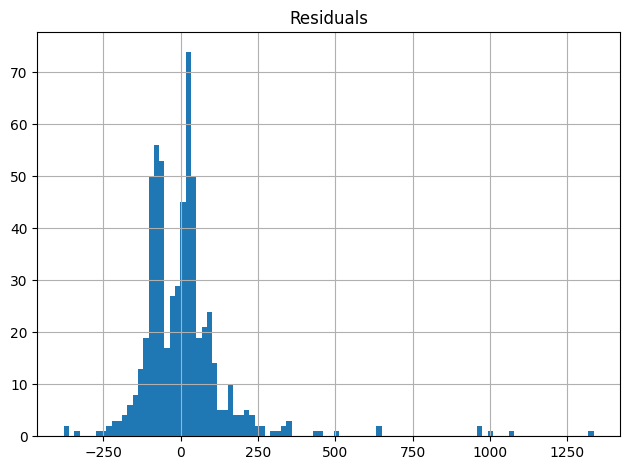

In [522]:
soft_lm_pred = soft_lm.predict(valid_X)
all_residuals = valid_y - soft_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%  ??? data에 맞게 수정해야 하나?? 효과없음 모든 잔차표시 됨
# print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))
print(len(all_residuals[(all_residuals > 500) & (all_residuals < 500)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=100)

plt.tight_layout()
plt.show()

In [523]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

   n     r2adj           AIC  Address_is_res  Freq  GenderMale     US  WebOrder  \
0  1  0.511111  17534.408102           False  True       False  False     False   
1  2  0.539375  17452.035283            True  True       False  False     False   
2  3  0.541731  17445.853916            True  True       False  False     False   
3  4  0.543677  17440.893143            True  True       False  False      True   
4  5  0.543814  17441.466934            True  True        True  False      True   
5  6  0.543567  17443.220345            True  True        True   True      True   

   last_update_days_ago  
0                 False  
1                 False  
2                  True  
3                  True  
4                  True  
5                  True  


## 후진제거

In [524]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: US, Freq, last_update_days_ago, WebOrder, GenderMale, Address_is_res
Start: score=17443.22
Step: score=17441.47, remove US
Step: score=17440.89, remove GenderMale
Step: score=17440.89, remove None
['Freq', 'last_update_days_ago', 'WebOrder', 'Address_is_res']


In [525]:
print(valid_X.head(5))
print(valid_y.head(5))

      US  Freq  last_update_days_ago  WebOrder  GenderMale  Address_is_res
674    1     2                  1346         0           1               1
1699   1     2                   434         1           0               0
1282   1     1                  3717         0           1               0
1315   1     9                  1128         1           1               0
1210   0     0                  2765         1           0               0
674        0
1699     184
1282       0
1315    1289
1210       0
Name: Spending, dtype: int64


In [537]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

               Mean Error (ME) : 8.0327
Root Mean Squared Error (RMSE) : 147.4527
     Mean Absolute Error (MAE) : 87.8026


In [512]:
best_variables

['Freq', 'Address_is_res', 'last_update_days_ago', 'WebOrder']

In [506]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: US, Freq, last_update_days_ago, WebOrder, GenderMale, Address_is_res
Start: score=17443.22
Step: score=17441.47, remove US
Step: score=17440.89, remove GenderMale
Step: score=17440.89, remove None
['Freq', 'last_update_days_ago', 'WebOrder', 'Address_is_res']


In [507]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: US, Freq, last_update_days_ago, WebOrder, GenderMale, Address_is_res
Start: score=18535.28, constant
Step: score=17534.41, add Freq
Step: score=17452.04, add Address_is_res
Step: score=17445.85, add last_update_days_ago
Step: score=17440.89, add WebOrder
Step: score=17440.89, unchanged None
['Freq', 'Address_is_res', 'last_update_days_ago', 'WebOrder']


In [508]:
print('\n0) Linear')
print('-------------------------------------------')
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

print('\n1) Lasso')
print('-------------------------------------------')
lasso = Lasso( alpha=1)
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))

# print('\n2) LassoCV')
# print('-------------------------------------------')
# lasso_cv = LassoCV( cv=5)
# lasso_cv.fit(train_X, train_y)
# regressionSummary(valid_y, lasso_cv.predict(valid_X))

print('\n2) Ridge')
print('-------------------------------------------')
ridge = Ridge(alpha=1)
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))

# print('\n4) BayesianRidge')
# print('-------------------------------------------')
# bayesianRidge = BayesianRidge()
# bayesianRidge.fit(train_X, train_y)
# regressionSummary(valid_y, bayesianRidge.predict(valid_X))


0) Linear
-------------------------------------------

Regression statistics

               Mean Error (ME) : 8.0327
Root Mean Squared Error (RMSE) : 147.4527
     Mean Absolute Error (MAE) : 87.8026

1) Lasso
-------------------------------------------

Regression statistics

               Mean Error (ME) : 8.2614
Root Mean Squared Error (RMSE) : 147.7349
     Mean Absolute Error (MAE) : 87.8448

2) Ridge
-------------------------------------------

Regression statistics

               Mean Error (ME) : 8.0401
Root Mean Squared Error (RMSE) : 147.6328
     Mean Absolute Error (MAE) : 88.0621


In [509]:
# run a linear regression of Price on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'Spending ~ ' + ' + '.join(predictors)

soft_lm = sm.ols(formula=formula, data=train_df).fit()
print(soft_lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Spending   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     278.7
Date:                Sun, 16 Apr 2023   Prob (F-statistic):          2.08e-234
Time:                        20:21:28   Log-Likelihood:                -8713.6
No. Observations:                1400   AIC:                         1.744e+04
Df Residuals:                    1393   BIC:                         1.748e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.1925 